# Grid Cells

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from grid_cells import GridCells, GridCellModule
from utils import gaussian_grid, device
from tqdm import tqdm


def dist(w, probs, place):
    return np.sum((probs.T @ w - place)**2 * (place + 0.1))

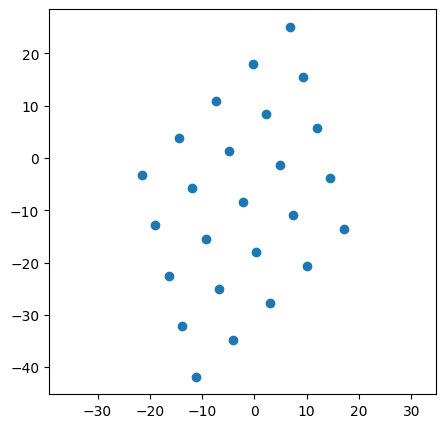

In [40]:
p = np.linspace(-25, 25, 5, endpoint=False)
phases = np.stack(np.meshgrid(p, p)).reshape(2, -1).T

theta = np.pi / 6
rot_angle = np.pi / 4
shear = np.asarray([[1, np.sin(theta)], [0, np.cos(theta)]]).T
rot = GridCellModule.rot2d(rot_angle).T

plt.figure(figsize=(5, 5))
plt.scatter(*(phases @ shear @ rot).T)
plt.axis('equal')
plt.show()

In [2]:
lin = np.linspace(-1, 1, 400)
coords = np.stack(np.meshgrid(lin, lin)).transpose(1, 2, 0)
coord = [0, 0]
mvn = multivariate_normal(mean=coord, cov=np.eye(2) * 0.001)
place = gaussian_grid(coords, [mvn])
place /= place.max()

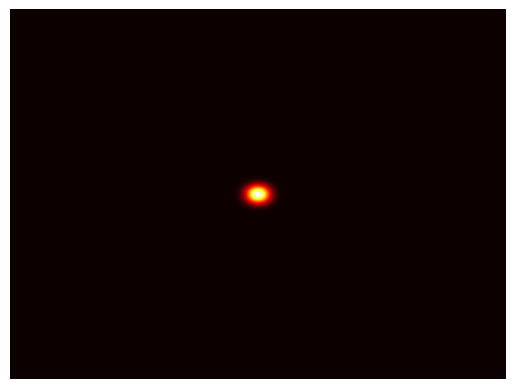

In [3]:
plt.contourf(place, levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [4]:
grid_cells = GridCells(np.linspace(80, 150, 10, dtype=int), n_per_module=25)
grid_cells.reset_modules(1)
grid_cells.compile_numpy()

In [5]:
grid_cells.shape

(250, 400, 400)

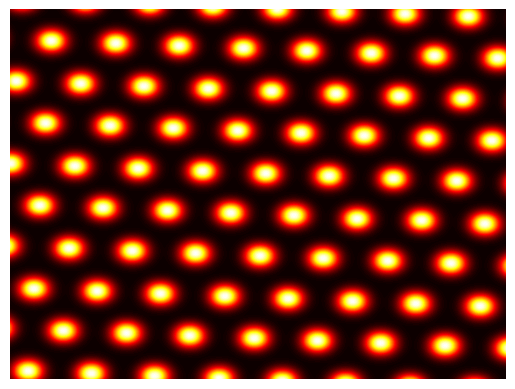

In [15]:
plt.contourf(grid_cells[0], levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [7]:
p = torch.tensor(grid_cells.grid_cells, dtype=torch.float32, device=device).permute(1, 2, 0)
w = torch.randn(grid_cells.shape[0], requires_grad=True, device=device)
pl = torch.tensor(place, dtype=torch.float32, device=device)
lr = 5e-6

for _ in tqdm(range(10000)):
    loss = torch.sum((p @ w - pl)**2 * (pl + 0.1))
    loss.backward(inputs=[w])
    w = w - lr * w.grad

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.72it/s]


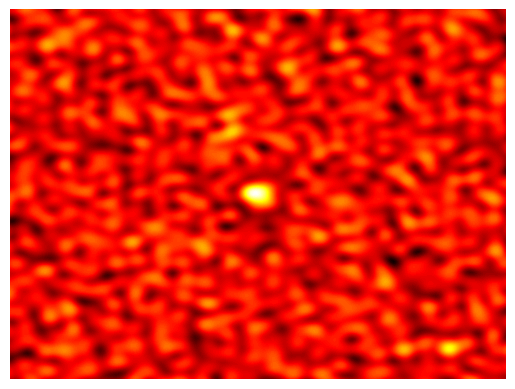

In [8]:
plt.contourf((p @ w).detach().cpu(), levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [9]:
coord = [-.5, -.5]
mvn = multivariate_normal(mean=coord, cov=np.eye(2) * 0.01)
place = gaussian_grid(coords, [mvn])
place /= place.max()

In [10]:
p = torch.tensor(grid_cells.grid_cells, dtype=torch.float32, device=device).permute(1, 2, 0)
w = torch.randn(grid_cells.shape[0], requires_grad=True, device=device)
pl = torch.tensor(place, dtype=torch.float32, device=device)
lr = 5e-6

for _ in tqdm(range(10000)):
    loss = torch.sum((p @ w - pl)**2 * (pl + 0.1))
    loss.backward(inputs=[w])
    w = w - lr * w.grad

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.22it/s]


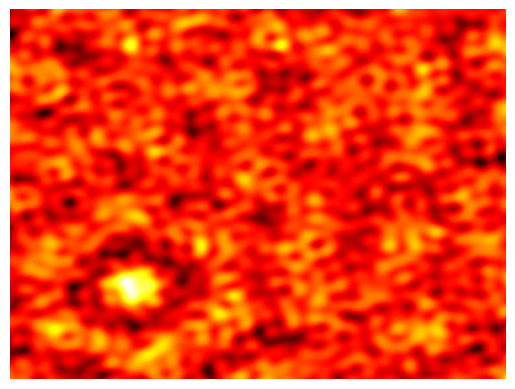

In [11]:
plt.contourf((p @ w).detach().cpu(), levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [12]:
grid_cells.reset_modules(2)
grid_cells.compile_numpy()

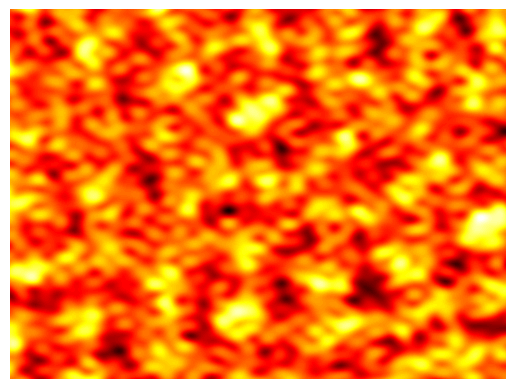

In [13]:
p = torch.tensor(grid_cells.grid_cells, dtype=torch.float32, device=device).permute(1, 2, 0)
plt.contourf((p @ w).detach().cpu(), levels=100, cmap='hot')
plt.axis('off')
plt.show()